In [16]:
import os, numpy as np
import os, sys
import numpy as np, sys, os, pandas, time
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
sys.path.append('/home/dkj755/AutoML')
SEED = 1000003

In [17]:
from train_utils import *
from ml_classifiers import *

logger = Record_Results('/home/dkj755/XRD/1Danalysis.log')


In [18]:
data_path = '/raid/dkj755/XRD'
# slac_path = 'SLAC-CSV'
# bruker_path = 'Bruker-PLT'

In [4]:
#2theta range [5.3659, 58.5664] having 1000 values
slac_files = [os.path.join(data_path, slac_path)+'/Sample3_fullwafer_t30_%004d_1D.csv'%x for x in range(1,178)]
def read_slac(x):
    return [[float(z) for z in y.strip().split(',')] for y in open(x).readlines()[4:]]
slac_data = np.swapaxes(np.array([read_slac(f) for f in slac_files]), 2,1)
print slac_data.shape, slac_data[0,:,0]
#Sample3_fullwafer_t30_0001_1D.csv

In [5]:
# #2theta range [10.000 to 40.000] and [30.000 and 60.000]
# br1_files = [os.path.join(data_path, bruker_path)+'/auto_PLT_file_%04d_0001.plt'%x for x in range(1,178)]
# br2_files = [os.path.join(data_path, bruker_path)+'/auto_PLT_file_%04d_0002.plt'%x for x in range(1,178)]
# def read_br(x):
#     return [[float(z) for z in y.strip().split()] for y in open(x).readlines()[16:]]
# br1_data = np.swapaxes(np.array([read_br(f) for f in br1_files]), 2,1)
# br2_data = np.swapaxes(np.array([read_br(f) for f in br2_files]), 2,1)
# print br1_data.shape, br2_data.shape, br1_data[0,:,0], br2_data[0,:,0]

In [6]:
slac_file_pre = os.path.join(data_path, 'wafer_data/SLAC_pre-bgsub.txt')
slac_file_post = os.path.join(data_path, 'wafer_data/SLAC_post-bgsub.txt')
br_file_pre = os.path.join(data_path, 'wafer_data/Bruker_XRD_pre-bgsub.txt')
br_file_post = os.path.join(data_path, 'wafer_data/Bruker_post-bgsub.txt')
def load_data(x):
    dat = [[float(z) for z in y.split()] for y in open(x).readlines()]
    dat = np.array(dat)
    print dat.shape
    return dat[0,:], dat[1:,:]
slac_pre_xvs, slac_pre_yvs = load_data(slac_file_pre)
slac_post_xvs, slac_post_yvs = load_data(slac_file_post)
slac_pre_yvs = slac_pre_yvs[:-1,:]
slac_post_yvs = slac_post_yvs[:-1,:]
print slac_pre_xvs.shape, slac_pre_yvs.shape, slac_post_xvs.shape, slac_post_yvs.shape
br_pre_xvs, br_pre_yvs = load_data(br_file_pre)
br_post_xvs, br_post_yvs = load_data(br_file_post)
print br_pre_xvs.shape, br_pre_yvs.shape, br_post_xvs.shape, br_post_yvs.shape

(179, 1000)
(179, 931)
(1000,) (177, 1000) (931,) (177, 931)
(178, 2501)
(178, 2026)
(2501,) (177, 2501) (2026,) (177, 2026)


In [7]:
def load_labels():
    comp_data = []
    comp_file = os.path.join(data_path, 'wafer_data', 'wafer_labels.txt')
    comp_fd = open(comp_file).read().strip().split('\n')
    #print comp_fd[0]
    for cd in comp_fd:
        cd = int(cd)-1
        comp_data.append(cd)
    comp_data = [x-1 if x > 0 else x for x in comp_data]
    return np.asarray(comp_data)
labels = load_labels()
print labels.shape

(177,)


In [8]:
def load_comp_data():
    comp_data = []
    comp_file = os.path.join(data_path, 'wafer_data', 'Composition.txt')
    comp_fd = open(comp_file).read().strip().split('\n')[1:]
    #print comp_fd[0]
    for cd in comp_fd:
        cd = [float(x) for x in  cd.split('\t')]
        comp_data.append(cd)
    return np.asarray(comp_data)
comp_data = load_comp_data()
print comp_data.shape

#print d

(177, 3)


In [32]:
import matplotlib.pylab as plt
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib import rc
import matplotlib.colors as colors
label_size = 10
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.family"] = "serif"
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams.update({'font.size':label_size, 'font.weight':'bold'})
tick_size = 10
dpi = 300
params = {'axes.labelsize': label_size,'axes.titlesize':label_size, 'legend.fontsize': label_size, 'xtick.labelsize': tick_size, 'ytick.labelsize': tick_size, 'axes.labelweight':'bold'}
plt.rcParams.update(params)
% matplotlib inline

set([0, 1, 2, 3, 4, 5, 6, 7])
0 26
1 15
2 24
3 32
4 13
5 37
6 7
7 23


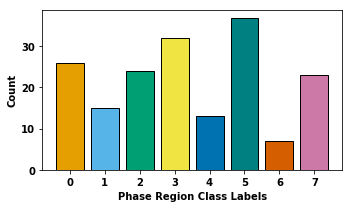

In [34]:
def plot_data(labels):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    rects = []
    colors = [
        (230, 159, 0),  # 41 orange
        (86, 180, 233),  # 202 sky blue
        (0, 158, 115),  # 164 bluish green
        (240, 228, 66),  # 56 yellow
        (0, 114, 178),  # 202 blue
        (0, 128, 128),  # teal
        (213, 94, 0),  # 27 vermillion
        (204, 121, 167),  # 326 reddish purple
        (0, 0, 0),  # --- black
    ]
    colors = [[i / 255. for i in color] for color in colors]

    data=labels
    data_set = set(labels)
    print data_set
    for d, l in enumerate(data_set):
        print l, len([x for x in data if x==l])
        rects.append(ax.bar([d], len([x for x in data if x==l]), color=colors[d], edgecolor='k', lw=1))
    ax.set_ylabel('Count')
    ax.set_xlabel('Phase Region Class Labels')
    ax.set_xticks(range(0,8))
    #ax.set_xticklabels(xvalues)
    #ax.legend(rects, legends, loc=legendposition)
    #if yrange is not None: ax.set_ylim(yrange)
    title = '/home/dkj755/XRD/Graphs/data_class'+'.png'
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    plt.close()
plot_data(labels)

In [11]:
from collections import Counter
SEED = 1234567
np.random.seed(SEED)
randomize = np.arange(177)
np.random.shuffle(randomize)
#print randomize
print Counter(labels)
for s in range(10):
    s_ind = int(1.*s/10 * 177)
    e_ind = int(1.*(s+1)/10 * 177)
    if s+1 == 10: e_ind = 177
    test_rand = randomize[s_ind:e_ind]
    train_rand = [x for x in randomize if x not in test_rand]
    print s, Counter(labels[test_rand])
    print s, Counter(labels[train_rand])
    print '\n'

Counter({5: 37, 3: 32, 0: 26, 2: 24, 7: 23, 1: 15, 4: 13, 6: 7})
0 Counter({0: 7, 3: 3, 1: 2, 5: 2, 2: 1, 4: 1, 6: 1})
0 Counter({5: 35, 3: 29, 2: 23, 7: 23, 0: 19, 1: 13, 4: 12, 6: 6})


1 Counter({5: 5, 2: 3, 7: 3, 0: 2, 1: 2, 4: 2, 3: 1})
1 Counter({5: 32, 3: 31, 0: 24, 2: 21, 7: 20, 1: 13, 4: 11, 6: 7})


2 Counter({2: 4, 7: 4, 0: 3, 3: 3, 1: 2, 5: 1, 6: 1})
2 Counter({5: 36, 3: 29, 0: 23, 2: 20, 7: 19, 1: 13, 4: 13, 6: 6})


3 Counter({5: 5, 3: 3, 4: 3, 1: 2, 6: 2, 0: 1, 2: 1})
3 Counter({5: 32, 3: 29, 0: 25, 2: 23, 7: 23, 1: 13, 4: 10, 6: 5})


4 Counter({5: 6, 0: 3, 2: 3, 7: 3, 1: 1, 3: 1, 4: 1})
4 Counter({3: 31, 5: 31, 0: 23, 2: 21, 7: 20, 1: 14, 4: 12, 6: 7})


5 Counter({3: 6, 7: 4, 0: 2, 2: 2, 5: 2, 4: 1, 6: 1})
5 Counter({5: 35, 3: 26, 0: 24, 2: 22, 7: 19, 1: 15, 4: 12, 6: 6})


6 Counter({3: 5, 0: 3, 5: 3, 1: 2, 7: 2, 2: 1, 4: 1})
6 Counter({5: 34, 3: 27, 0: 23, 2: 23, 7: 21, 1: 13, 4: 12, 6: 7})


7 Counter({2: 5, 3: 5, 5: 3, 0: 2, 1: 1, 4: 1, 7: 1})
7 Counter({5: 34, 3:

In [27]:
def scatter_plot(xvs, yvs, title, xran=[4,60]):
    fig, ax  = plt.subplots(1, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, yvs.shape[0]))
    for j, c in zip(range(yvs.shape[0]), colors):
            ax.plot(xvs, yvs[j], color=c)
    ax.set_xlim(xran)
    print min(xvs), max(xvs)
    #ax[i].set_ylim(0, data[i].shape[0]+5)
    ax.set_xlabel(r'$2\theta$')
    ax.set_ylabel('Intensity')
    fig = plt.gcf()
    fig.set_size_inches(4,3)
    plt.tight_layout()
    plt.savefig(title)
    plt.show()
    plt.close()

5.3659 58.566


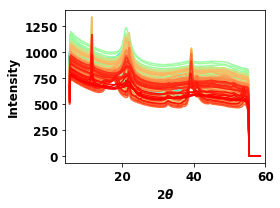

5.8231 55.105


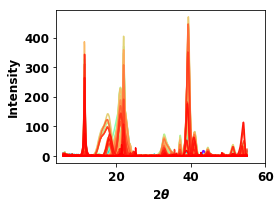

10.0 60.0


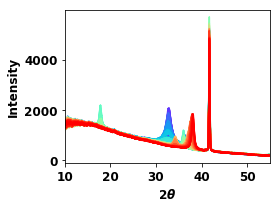

15.98 56.48


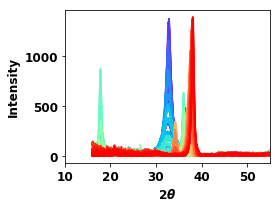

In [28]:
os.system('mkdir -p /home/dkj75/XRD/Graphs')
scatter_plot(slac_pre_xvs, slac_pre_yvs, '/home/dkj755/XRD/Graphs/SLAC_pre_bg_1D.png')
scatter_plot(slac_post_xvs, slac_post_yvs, '/home/dkj755/XRD/Graphs/SLAC_post_bg_1D.png')
scatter_plot(br_pre_xvs, br_pre_yvs, '/home/dkj755/XRD/Graphs/Bruker_pre_bg_1D.png', xran=(10,55))
scatter_plot(br_post_xvs, br_post_yvs, '/home/dkj755/XRD/Graphs/Bruker_post_bg_1D.png', xran=(10,55))

In [14]:
logger.fprint('\n\nSLAC Results')
run_classifiers(slac_post_yvs, labels, logger=logger)
logger.fprint('\n\nBruker Results')
run_classifiers(br_post_yvs, labels, logger=logger)



SLAC Results
start training

current classifier: LogisticRegression
None
model for grid search: LogisticRegression
parameter for grid search: {}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:605: Warning:

The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.



Accuracy: 0.5056 (+/- 0.1591)

current classifier: DecisionTree
None
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 2}
Accuracy: 0.3478 (+/- 0.1404)
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 5}
Accuracy: 0.3291 (+/- 0.1546)
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 10}
Accuracy: 0.2613 (+/- 0.1718)

current classifier: RandomForest
None
model for grid search: RandomForest
parameter for grid search: {'max_features': 0.25, 'min_samples_split': 2, 'random_state': 1983, 'n_estimators': 2, 'max_depth': 5}
Accuracy: 0.2010 (+/- 0.1619)
model for grid search: RandomForest
parameter for grid search: {'max_features': 0.25, 'min_samples_split': 2, 'random_state': 1983, 'n_estimators': 5, 'max_depth': 5}
Accuracy: 0.2587 (+/- 0.2773)
model for grid search: RandomForest
parameter for grid search: {'max_features': 0.25, 'min_samples_split': 2, 'random_state': 1983, 'n_estimators': 10, 'max_depth': 5}

In [15]:
slac_yvs = np.concatenate((slac_post_yvs, comp_data), axis=1)
print slac_yvs.shape
logger.fprint('\n\nSLAC Results with comp')
run_classifiers(slac_yvs, labels, logger=logger)
br_yvs = np.concatenate((br_post_yvs, comp_data), axis=1)
print br_yvs.shape
logger.fprint('\n\nBruker Results with comp')
run_classifiers(br_post_yvs, labels, logger=logger)

logger.fprint('\n\nonly with comp')
run_classifiers(comp_data, labels, logger=logger)

(177, 934)


SLAC Results with comp
start training

current classifier: LogisticRegression
None
model for grid search: LogisticRegression
parameter for grid search: {}
Accuracy: 0.5690 (+/- 0.2075)

current classifier: DecisionTree
None
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 2}
Accuracy: 0.4936 (+/- 0.1827)
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 5}
Accuracy: 0.6058 (+/- 0.1530)
model for grid search: DecisionTree
parameter for grid search: {'max_depth': 10}
Accuracy: 0.6252 (+/- 0.1912)

current classifier: RandomForest
None
model for grid search: RandomForest
parameter for grid search: {'max_features': 0.25, 'min_samples_split': 2, 'random_state': 1983, 'n_estimators': 2, 'max_depth': 5}
Accuracy: 0.4912 (+/- 0.1796)
model for grid search: RandomForest
parameter for grid search: {'max_features': 0.25, 'min_samples_split': 2, 'random_state': 1983, 'n_estimators': 5, 'max_depth': 5}
Accuracy: 0.5899 (+/- 0.1858)